# Twitter data mining and basic sentiment analysis using the colombian peace treaty as an example

The following notebook shows a basic process to mine tweets from the tweeter API using the python tweepy library, and a series of methods -from a custom script to overpass the API date retreival limitation, to manipulaate the text data to eliminate punctuation signs, stop words, and obtain separate hashtags for each tweet, to tokenise each word, in order to obtain the most used terms and hashtags for a particular topic (in this case the anouncement of the Colombian goverment of a peace treaty with the FARC guerrilas)

This worked is based on the comprehensive compilation of this topic made by Marco Bonzanini in his Tech diary related to basic sentiment analysis in twitter, and complemented with toold from Jefferson-Henrique and other contributors found on stack overflow.

In [1]:
#Import Tweepy library to connect to the twitter API
#All keys have been removed for privacy of my account

import tweepy
from tweepy import OAuthHandler
 
consumer_key = 'YOURKEY'
consumer_secret = 'YOURKEY'
access_token = 'YOURKEY'
access_secret = 'YOURKEY'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [2]:
#Importing required modules
import json
import got
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
csfont = {'fontname':'Arial'}
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('jpmora', '63aq6fwdpj')
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn.cross_validation import train_test_split
from sklearn import svm
from datetime import datetime
import cufflinks as cf

In [ ]:
#Creating a function to check the functionality of tweepy by printing the feed of tweets from my account
def process_or_store(tweet):
    print(json.dumps(tweet))

In [ ]:
#Priving the functionality of tweepy by extracting all of the friends in my personal account
for friend in tweepy.Cursor(api.friends).items():
    process_or_store(friend._json)

In [ ]:
#Creating a test quesry for a defined term and a defined range using tweepy and orinting the results
tweetCriteria = got.manager.TweetCriteria().setQuerySearch('plebiscito').setSince("2016-10-06").setUntil("2016-10-07").setMaxTweets(2)
tweet = got.manager.TweetManager.getTweets(tweetCriteria)[1]

print tweet.text

In [ ]:
#Running a preset script based on Tweepy to retreive tweets from the API from a defined time range
#and a defined set of terms
#Credits to Jefferson-Henrique (http://jeffersonhenrique.com) for this script
%run Exporter.py --querysearch "acuerdo de paz" --since 2016-08-25 --until 2016-08-28 

In [3]:
#Reading in the resuting tweet CSV file as a pandas dataframe
data = pd.read_csv('output_got.csv', delimiter = ';', error_bad_lines=False, encoding='utf-8')

Skipping line 2418: expected 10 fields, saw 11
Skipping line 3972: expected 10 fields, saw 11
Skipping line 4350: expected 10 fields, saw 11
Skipping line 16579: expected 10 fields, saw 11
Skipping line 16945: expected 10 fields, saw 11



In [4]:
#Printing the frame head
data.head(5)

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,Union_Europea,2016-08-27 19:56,0,0,Unión Europea celebra Acuerdo de Paz en Colomb...,NaN,NaN,#UE #UnionEuropea,7.696851e+17,https://twitter.com/Union_Europea/status/76968...
1,DragonTauro,2016-08-27 19:55,0,0,Las FARC convocaron a sus delegados para ratif...,NaN,NaN,NaN,7.696848e+17,https://twitter.com/DragonTauro/status/7696847...
2,drvargasquemba,2016-08-27 19:55,27,9,Entrevista con la Cadena COPE de España denunc...,NaN,NaN,NaN,7.696847e+17,https://twitter.com/drvargasquemba/status/7696...
3,venezuelaaldia,2016-08-27 19:53,0,1,Filipina espera acuerdo de paz con los rebelde...,NaN,NaN,NaN,7.696844e+17,https://twitter.com/venezuelaaldia/status/7696...
4,pormillano,2016-08-27 19:53,0,0,escuche los acuerdos; Visítelo en el siguiente...,NaN,NaN,NaN,7.696842e+17,https://twitter.com/pormillano/status/76968424...


In [5]:
data.text[0]

u'Uni\xf3n Europea celebra Acuerdo de Paz en Colombia como ... - Deutsche Welle http:// goo.gl/fb/WqJB29 #UE #UnionEuropea'

In [6]:
#Getting the lenght of the frame (or number of valid tweets for the query performed)
len(data)

18250

In [7]:
#Getting a base count of the different hashtags we see in the mined tweets
#The roblem with this approach is that many lines have more than 1 hashtag at the same time
data.hashtags.value_counts().nlargest(5)

#Colombia          276
#spreaker          102
#Colombia #FARC     90
#Internacional      90
#NoTextAndDrive     83
Name: hashtags, dtype: int64

In [8]:
#First step to standarize the text data is to unifiy all text into lower cases
data['text'] = data.text.str.lower()

In [9]:
#In order to obtain valid URL's in the tweets as individual tokens, we edit the / sign
#To delete any blank spaces
data['text'] = data['text'].str.replace('/ ' , '/')

In [10]:
#Finally we also reduces any spaces existing after the www characther to obtain valid URL's
data['text'] = data['text'].str.replace('w. ', 'w.')

In [11]:
#we print a example of the data contained in a single dowloaded tweet to validate 
#Our changes
data['text'][0]

u'uni\xf3n europea celebra acuerdo de paz en colombia como ... - deutsche welle http://goo.gl/fb/wqjb29 #ue #unioneuropea'

In [12]:
#We perform the same change in the text found in the hashtags (lower all cases)
data['hashtags'] = data.hashtags.str.lower()

In [13]:
#Then, in order to separate multiple hashtags from a single line we split the text
#In the line, and expand all values to different columns in a frame
hashtags = data.hashtags.str.split(' ', expand=True)

In [14]:
#Here we can see tthe final result
hashtags.head()

,0,1,2,3,4,5,6,7
0,#ue,#unioneuropea,None,None,None,None,None,None
1,NaN,None,None,None,None,None,None,None
2,NaN,None,None,None,None,None,None,None
3,NaN,None,None,None,None,None,None,None
4,NaN,None,None,None,None,None,None,None


In [15]:
#In that form we could potentially sum all values to obtain the most used hashtags
#However we would have to sum up all values in each column
hashtags[0].value_counts().nlargest(10)

#colombia           523
#acuerdodepaz       176
#noticias           158
#internacional      112
#sialapaz           107
#spreaker           105
#farc               103
#paz                 96
#internacionales     88
#pazencolombia       86
Name: 0, dtype: int64

In [16]:
#To obtain the actual text for each tweet we split each word
splittext = data.text.str.split(' ')

In [17]:
#This is the result when we have an individual token for each word in each tweet
splittext.head()

0    [unión, europea, celebra, acuerdo, de, paz, en...
1    [las, farc, convocaron, a, sus, delegados, par...
2    [entrevista, con, la, cadena, cope, de, españa...
3    [filipina, espera, acuerdo, de, paz, con, los,...
4    [escuche, los, acuerdos;, visítelo, en, el, si...
Name: text, dtype: object

In [18]:
#We could also convert all text into a numpy array for ease in the analysis
#Using the same split string functionality, and comma as a separator for each token (word) 
text = np.array(data.text.str.cat(sep=', ').split(' '))

In [19]:
#This is the final result
text

array([u'uni\xf3n', u'europea', u'celebra', ..., u'de', u'#paz',
       u'http://ow.ly/n8bg303yhdb'], 
      dtype='<U508')

In [20]:
#Then we proceed to remove punctuation signs that are not useful
text = map(lambda each:each.strip(":"), text)

In [21]:
#In that way we can obtain a first version of the most used words in all mined tweets
#However this list still contains stop words; we'll deal with that later
pd.DataFrame(Counter(text).most_common(30))

,0,1
0,de,26708
1,acuerdo,17228
2,paz,16960
3,el,12236
4,las,7724
5,colombia,7132
6,y,7086
7,farc,7058
8,en,5743
9,la,5267


In [22]:
#We can perform the same procedure to the hashtags column, to obtain a single list that is 
#Easy to parse and count
hashtags1 = np.array(data.hashtags.str.cat(sep=', ').split(' '))

In [23]:
#We remove in this case some commas that are problematic
hashtags1 = map(lambda each:each.strip(","), hashtags1)

In [24]:
#In this form we can obtain a sorted rank of the most used hashtags in this
#Mined Tweeets
pd.DataFrame(Counter(hashtags1).most_common(20))

,0,1
0,#colombia,845
1,#farc,401
2,#acuerdodepaz,262
3,#noticias,191
4,#paz,179
5,#sialapaz,163
6,#internacional,122
7,#pazencolombia,120
8,#spreaker,114
9,#adiosalaguerra,108


In [25]:
hashtags = pd.DataFrame(Counter(hashtags1).most_common(10))
hashtags.columns = ['hashtags', 'count']

In [26]:
hashtags = hashtags.set_index('hashtags')

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.]),
 <a list of 10 Text yticklabel objects>)

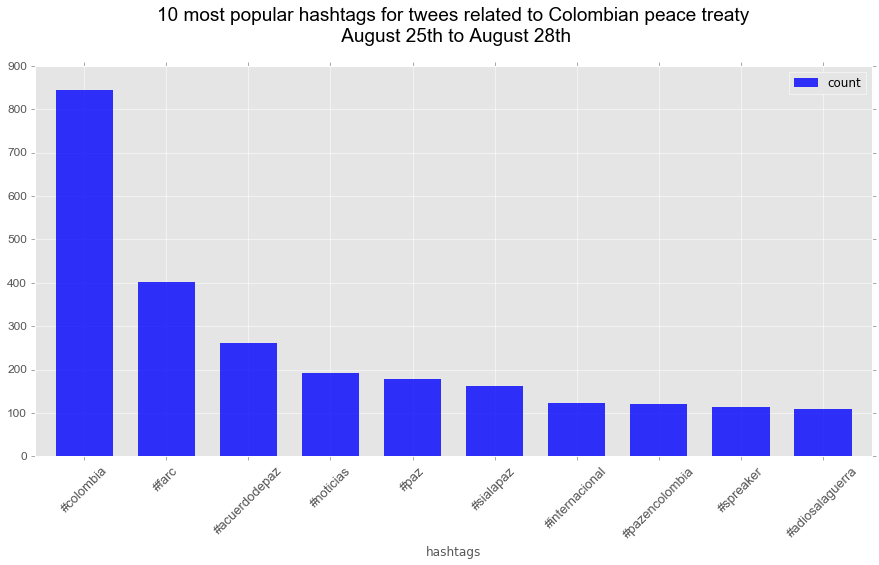

In [27]:
#Creating a plot for 10 most common hashtags using Matplotlib
plt.figure()

ax = hashtags.plot(kind='bar', color = 'blue', figsize=(15,7), alpha=0.8, width=0.7, linewidth=0, label=False)
#ax.yaxis.grid()
plt.title('10 most popular hashtags for twees related to Colombian peace treaty\n August 25th to August 28th', \
          y=1.05, fontsize=19, **csfont)
plt.xticks(rotation=45, fontsize=13, **csfont)
plt.yticks(fontsize=12, **csfont)

In [28]:
hashtags = hashtags.reset_index()

In [83]:
#Creating the same plot this time using pyplot, a more iteractive ploting library
hashtags2 = [
    go.Bar(
        x=hashtags['hashtags'],
        y=hashtags['count'])
]
layout = go.Layout(title= '10 most popular hashtags for twees related to Colombian peace treaty<br> August 25th to August 28th', \
                   titlefont=dict(family='Arial', size=26), yaxis=dict(title='Number of tweets', titlefont=dict(size=16)))
fig = go.Figure(data=hashtags2, layout=layout)
py.iplot(fig, filename='10 hashtags')

In [30]:
#We are now going to import a library called nltk
#very useful for natural languaje processing, in order to remove stop words
#We download the dictionary "stopwords" with the second command
import nltk

In [31]:
#Then from the strings library we import the punctuation list
#and from nklt the stop words list in this case for spanish
#I decided to add some aadditional terms that I want to remove in order to obatin a cleaner
#list of the most used words
punctuation = list(string.punctuation)
punctuation2 = punctuation + [u"'" + u'"' + u'\xa1', u'\xbf']
stop = stopwords.words('spanish') + punctuation + ['rt', 'via', u'', u'\u2026,', u'\u2026', u'...', u'...,']

In [32]:
#Using a list comprehension a create an uptaded list of words
#with all stop words and punctuation signs removed
text1 = [term for term in text if term not in stop]

In [33]:
#Which results in a cleaner list of the 15 most used words in the  mined tweets that I found
commonwords = pd.DataFrame(Counter(text1).most_common(15))
commonwords.columns = ['word', 'count']
commonwords

,word,count
0,acuerdo,17228
1,paz,16960
2,colombia,7132
3,farc,7058
4,gobierno,3498
5,felicita,1668
6,santos,1529
7,tras,1451
8,obama,1293
9,colombianos,985


In [85]:
#Creating the same plot this time using pyplot, a more iteractive ploting library
words2 = [
    go.Bar(
        x=commonwords['word'],
        y=commonwords['count'], marker=dict(color='rgb(255,0,0)'), opacity=0.6)
]
layout = go.Layout(title= '15 most commonly used words in twees related to Colombian peace <br> treaty August 25th to August 28th', \
                   titlefont=dict(family='Arial', size=26),  yaxis=dict(title='Number of appearances', titlefont=dict(size=16)))
fig = go.Figure(data=words2, layout=layout)
py.iplot(fig, filename='15 common words')

In [35]:
#I'm also going to use a very useful function from nklt called "bigrams"
#this allows to obtain a list of the most common combination of words in the 
#mined tweets that are adyacent to each other
from nltk import bigrams  
terms_bigram = bigrams(text1)

In [36]:
#This give us a very useful view not only of the most used words, but the most
#common adjacent two word combinations in the tweets
bigrams = pd.DataFrame(Counter(terms_bigram).most_common(15))
bigrams.columns = ['bigrams', 'count']
bigrams

,bigrams,count
0,"(acuerdo, paz)",16238
1,"(paz, farc)",2497
2,"(colombia, farc)",2174
3,"(paz, colombia)",2093
4,"(gobierno, colombia)",1523
5,"(paz, gobierno)",1229
6,"(obama, felicita)",859
7,"(firma, acuerdo)",818
8,"(colombia, acuerdo)",792
9,"(gobierno, farc)",783


In [37]:
brigrams_list = bigrams['bigrams'].tolist()

In [86]:
#Creating the same plot this time using pyplot, a more iteractive ploting library
bigrams2 = [
    go.Bar(
        x=['-'.join(brigrams_list[i]) for i in range (0, len(brigrams_list))],
        y=bigrams['count'], marker=dict(color='rgb(0,128,64)'), opacity=0.6)
]
layout = go.Layout(title= '15 most common adjacent terms for twees related to Colombian peace treaty<br> August 25th to August 28th', \
                   titlefont=dict(family='Arial', size=26), yaxis=dict(title='Number of appearances', titlefont=dict(size=16)))
fig = go.Figure(data=bigrams2, layout=layout)
py.iplot(fig, filename='Bigrams')

In [39]:
tweetlist = []
for i in range (0, len(splittext)):
    a = [term for term in splittext[i] if term not in stop]
    tweetlist.append(a)

In [40]:
tweetlist1 = []
for i in range (0, len(tweetlist)):
    a= [term.rstrip(''.join(punctuation)) for term in tweetlist[i]]
    tweetlist1.append(a)

In [41]:
tweetlist2 = []
for i in range (0, len(tweetlist1)):
    tweetlist2.append([term for term in tweetlist1[i] if term not in stop if "@" not in term\
                           if '#' not in term if term.startswith('http:') == False if '/' not in term])

In [42]:
tweetlist3 = []
for i in range (0, len(tweetlist2)):
    a= [term.lstrip(''.join(punctuation2)) for term in tweetlist2[i]]
    tweetlist3.append(a)

In [43]:
tweetlistws = []
for i in range (0, len(tweetlist3)):
    a = " ".join(tweetlist3[i])
    tweetlistws.append(a)

In [44]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2)) 
co_occurrences = bigram_vectorizer.fit_transform(tweetlistws)
sum_occ = np.sum(co_occurrences.todense(),axis=0)

In [45]:
co_occurrence_df = pd.DataFrame(sorted((zip(bigram_vectorizer.get_feature_names(),np.array(sum_occ)[0].tolist())),\
                                       key=lambda x: x[1], reverse=True)[:20])

In [46]:
co_occurrence_df.columns = ['terms', 'co-ocurrence']

In [47]:
co_occurrence_df

,terms,co-ocurrence
0,acuerdo paz,16474
1,paz farc,2836
2,paz colombia,2513
3,colombia farc,2465
4,gobierno colombia,1549
5,paz gobierno,1260
6,histórico acuerdo,918
7,gobierno farc,906
8,obama felicita,859
9,firma acuerdo,824


In [48]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(40, 100)

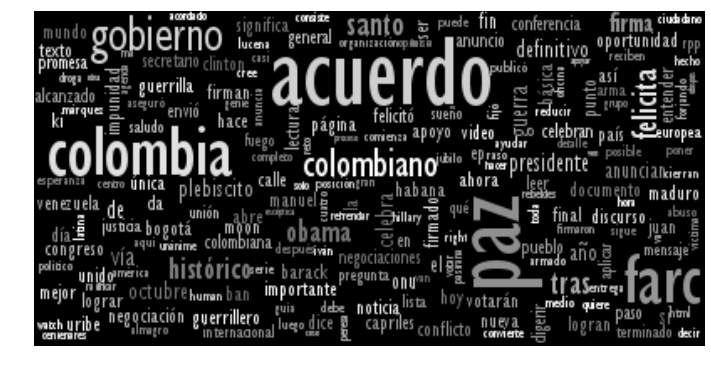

In [49]:
from wordcloud import WordCloud, ImageColorGenerator
wc = WordCloud(font_path  = 'C:\Windows\Fonts\GILC____.TTF', max_font_size=60, \
               relative_scaling=.5, max_words=200).generate(' '.join(tweetlistws))
default_colors = wc.to_array()
plt.figure(figsize = (12,12))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
wc.to_file("wordcloud_colombia.png")
plt.axis("off")
plt.show()

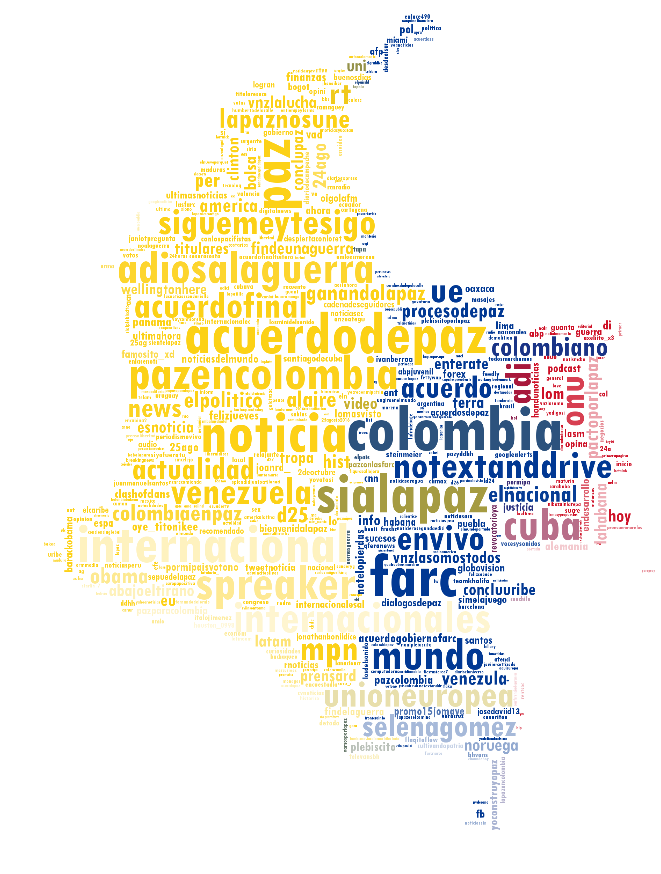

In [50]:
from PIL import Image
from scipy.misc import imread

colombia_coloring = imread("Colombia - flag.jpg")

wc = WordCloud(font_path  = 'C:\Windows\Fonts\TCCB____.TTF', background_color="white", \
               max_words=500, mask=colombia_coloring, random_state=10, relative_scaling=.1)
# generate word cloud
wc.generate(" ".join(hashtags1))
image_colors = ImageColorGenerator(colombia_coloring)

# show
plt.figure(figsize = (15,15))
plt.imshow(wc.recolor(color_func=image_colors))
# store to file
wc.to_file("colombia.png")
plt.axis("off")
plt.show()

In [51]:
tassdata = pd.read_csv('Tass_final.csv', encoding='utf-8')

In [52]:
tassdata = tassdata.ix[:,'text':]

In [53]:
tassdata.head()

,text,values
0,portada público viernes fabra banquillo orden ...,N
1,gonzalo altozano tras presentación libro 101 e...,P
2,mañana gaceta tve pagamos culpa becaria falsa ...,N
3,mañana gaceta amaiur depende uxue barkos crear...,N
4,buenas noches followercetes mañana va ser día ...,P


In [54]:
len(tassdata)

45396

In [55]:
coldata = pd.DataFrame(tweetlistws,  index=None, columns = ['text'])

In [56]:
coldata.head()

,text
0,unión europea celebra acuerdo paz colombia deu...
1,farc convocaron delegados ratificar acuerdo paz
2,entrevista cadena cope españa denunciando tram...
3,filipina espera acuerdo paz rebeldes comunistas
4,escuche acuerdos visítelo siguiente hipervíncu...


In [57]:
len(coldata)

18250

In [58]:
combined = tassdata.append(coldata)
combined = combined.reset_index()
del(combined['index'])

In [59]:
combined.head()

,text,values
0,portada público viernes fabra banquillo orden ...,N
1,gonzalo altozano tras presentación libro 101 e...,P
2,mañana gaceta tve pagamos culpa becaria falsa ...,N
3,mañana gaceta amaiur depende uxue barkos crear...,N
4,buenas noches followercetes mañana va ser día ...,P


In [60]:
combined.tail()

,text,values
63641,siento emoción tan grande ver firma acuerdo pa...,NaN
63642,calificación acuerdo paz depende colombianos h...,NaN
63643,calificación acuerdo paz depende colombianos h...,NaN
63644,gobierno colombiano farc sellan histórico acue...,NaN
63645,negociadores gobierno colombiano confirman hoy...,NaN


In [61]:
vectorizer = CountVectorizer(min_df=5, max_df = 0.5, ngram_range=(1,2))
vectors = vectorizer.fit_transform(combined['text'].values.astype('U'))

In [62]:
(vectors[:45396])

<45396x18610 sparse matrix of type '<type 'numpy.int64'>'
	with 403682 stored elements in Compressed Sparse Row format>

In [63]:
lin_svc = svm.LinearSVC(max_iter=4000, multi_class='ovr', random_state=None, penalty='l2', \
                       loss='squared_hinge', C=.1, tol=0.0001)
lin_svc.fit(vectors[:45396], combined['values'][:45396])

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=4000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [64]:
prediction = pd.DataFrame(lin_svc.predict(vectors[45396:]), columns = ['value'])

In [65]:
prediction.head()

,value
0,P
1,P
2,N
3,N
4,P


In [66]:
finalcol = pd.concat([data, prediction], axis=1)

In [67]:
finalcol.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,value
0,Union_Europea,2016-08-27 19:56,0,0,unión europea celebra acuerdo de paz en colomb...,NaN,NaN,#ue #unioneuropea,7.696851e+17,https://twitter.com/Union_Europea/status/76968...,P
1,DragonTauro,2016-08-27 19:55,0,0,las farc convocaron a sus delegados para ratif...,NaN,NaN,NaN,7.696848e+17,https://twitter.com/DragonTauro/status/7696847...,P
2,drvargasquemba,2016-08-27 19:55,27,9,entrevista con la cadena cope de españa denunc...,NaN,NaN,NaN,7.696847e+17,https://twitter.com/drvargasquemba/status/7696...,N
3,venezuelaaldia,2016-08-27 19:53,0,1,filipina espera acuerdo de paz con los rebelde...,NaN,NaN,NaN,7.696844e+17,https://twitter.com/venezuelaaldia/status/7696...,N
4,pormillano,2016-08-27 19:53,0,0,escuche los acuerdos; visítelo en el siguiente...,NaN,NaN,NaN,7.696842e+17,https://twitter.com/pormillano/status/76968424...,P


In [68]:
polarity = pd.DataFrame(finalcol.value.value_counts()).reset_index()
polarity.columns = ['value', 'count']

In [69]:
polarity

,value,count
0,P,15543
1,N,2523
2,NEU,184


In [70]:
figure = polarity.iplot(kind='pie',labels='value',values='count', pull=.1,hole=.5, \
               title = 'Projected polarity values for twees related to Colombian peace treaty<br> August 25th to August 28th' \
              , colors = ['blue', 'red', 'black'], asFigure=True)

In [71]:
figure['layout']['titlefont'] = {'color': '#4D5663', "size": 24}

In [72]:
figure['layout']['legend']['font'] = {'color': '#4D5663', "size" : 16}

In [73]:
py.iplot(figure, filename='pie chart customized')

In [74]:
type(finalcol.date[0])

unicode

In [75]:
finalcol['date'] = finalcol['date'].str[:13]

In [76]:
finalcol['date'] = pd.to_datetime(finalcol['date'] ,infer_datetime_format=True)

In [77]:
positive = finalcol[finalcol['value'] == 'P']
negative = finalcol[finalcol['value'] == 'N']
neutral = finalcol[finalcol['value'] == 'NEU']

In [78]:
data = [
    go.Scatter(
        x=positive.groupby('date').count().index, # assign x as the dataframe column 'x'
        y=positive.groupby('date').count()['value'],
        name='Positive tweets'
    ),
    go.Scatter(
        x=negative.groupby('date').count().index, # assign x as the dataframe column 'x'
        y=negative.groupby('date').count()['value'],
        name='Negative tweets', marker=dict(color='rgb(255,0,0)'), opacity=0.6
    )
    
]
layout = go.Layout(title= 'Projected polarity trend for tweets related to Colombian peace treaty<br> August 25th to August 28th', \
                   titlefont=dict(family='Arial', size=26), 
                   yaxis=dict(title='Number of tweets'),
    xaxis=dict(title='Date and time'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jpmora/0 or inside your plot.ly account where it is named 'basic-bar'
